# Density Matrices Scalings - Many-Body Wavefunctions

Author: Paolo Zinesi

In [19]:
import numpy as np
from numpy import random
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from scipy.optimize import curve_fit

color_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# function used in fits
def exp_fit(x, C, base):
    return C * (base**x)

save_plots = True

$$\psi_i \in \mathcal{H}^D$$

$$ |\Psi \rangle = \sum_{\alpha_1,\dots,\alpha_N} \Psi_{\alpha_1,\dots,\alpha_N} |\alpha \rangle _1 \otimes \dots \otimes |\alpha \rangle _N$$

Note: a separable wavefunction numpy array with $N$ complex128 elements occupies a dimension of $16 N D$ bytes.


## Plots

### Separable and general wavefunction testing

In [2]:
wf_df = pd.read_csv("results/wavefunc_perf.csv", header=0, dtype={"N":int, "D":int, "dim_bytes":int})
wf_df

,N,D,type,dim_bytes,time
0,2,2,separable,64,0.000381
1,2,2,general,64,0.000079
2,2,2,separable,64,0.000104
3,2,2,general,64,0.000065
4,2,2,separable,64,0.000110
...,...,...,...,...,...
289,8,8,general,268435456,1.337515
290,8,8,separable,1024,0.000194
291,8,8,general,268435456,1.267646
292,8,8,separable,1024,0.000189


In [3]:
# groupby repetitions of the same configuration
# then take the average, std and rename columns 
agg_df = wf_df.groupby(["N", "D", "type", "dim_bytes"]).agg(["mean", "std"])
agg_df.columns = ['_'.join(col) for col in agg_df.columns.to_flat_index().values]
agg_df.reset_index(inplace=True)
agg_df

,N,D,type,dim_bytes,time_mean,time_std
0,2,2,general,64,0.000077,0.000011
1,2,2,separable,64,0.000198,0.000158
2,2,3,general,144,0.000069,0.000001
3,2,3,separable,96,0.000080,0.000010
4,2,4,general,256,0.000080,0.000018
...,...,...,...,...,...,...
93,8,6,separable,768,0.000142,0.000061
94,8,7,general,92236816,0.465041,0.015188
95,8,7,separable,896,0.000158,0.000012
96,8,8,general,268435456,1.297831,0.035890


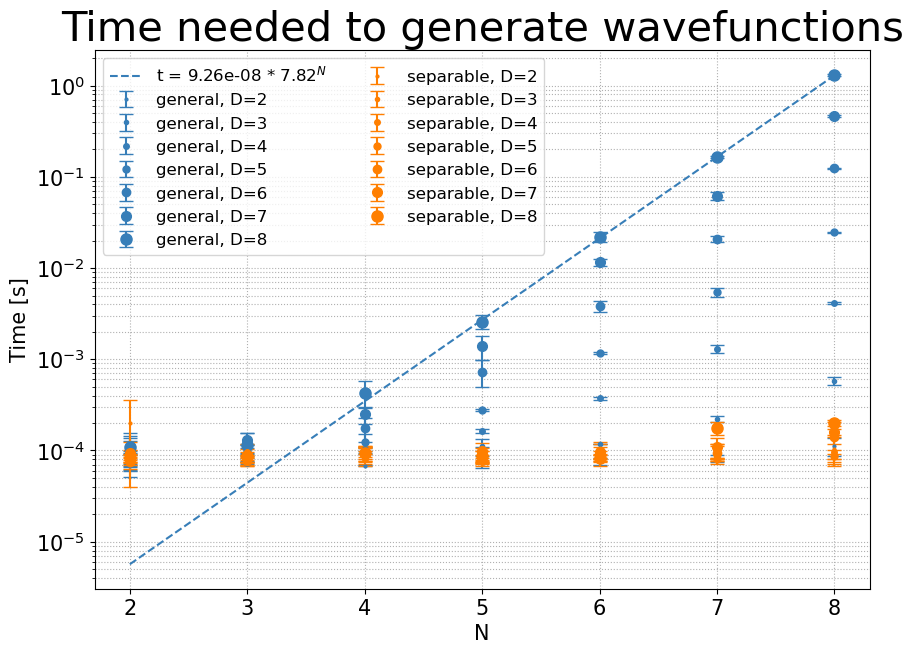

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
D_list = np.sort(np.unique(agg_df["D"]))

# plot all the desider plots
for i, type_ in enumerate(["general", "separable"]):
    for D_ in D_list:
        plot_df = agg_df[(agg_df["type"]==type_) & (agg_df["D"]==D_)]
        ax.errorbar(x="N", y="time_mean", yerr="time_std", data=plot_df,
                    fmt="o", c=color_palette[i], ms=D_, label=f"{type_}, D={D_}", capsize=5)

# fit general wavefunction with greatest D
fit_df = agg_df[(agg_df["type"]=="general") & (agg_df["D"]==np.max(D_))]
popt, pcov = curve_fit(f=exp_fit, xdata=fit_df.loc[fit_df["N"]>3,"N"], ydata=fit_df.loc[fit_df["N"]>3,"time_mean"],
                        sigma=fit_df.loc[fit_df["N"]>3,"time_std"], p0=[1.0e-05, 1.0])
ax.plot(fit_df["N"], exp_fit(fit_df["N"], *popt), ls='dashed', label=f"t = {popt[0]:.2e} * {popt[1]:.2f}$^N$", c=color_palette[0])


ax.set_title("Time needed to generate wavefunctions", fontsize=30)
ax.set_xlabel("N", fontsize=15)
ax.set_ylabel("Time [s]", fontsize=15)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.grid(True, which="both", linestyle=":")
ax.set_yscale("log")
ax.legend(fontsize=12, ncol=2)

if save_plots:
    fig.savefig("results/wavefunc_time.png", dpi=400, format='png')

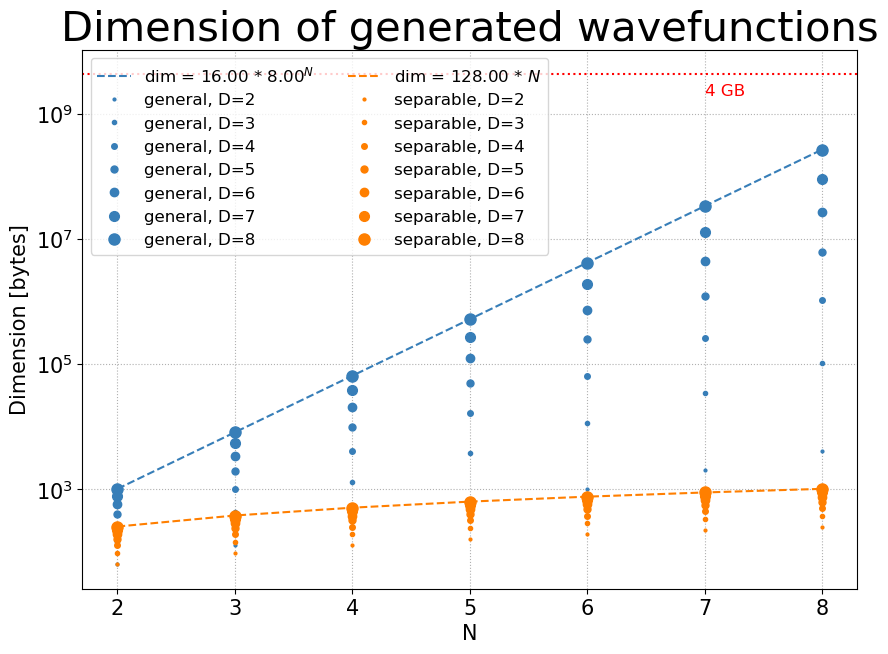

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
D_list = np.sort(np.unique(agg_df["D"]))

# plot all the desider plots
for i, type_ in enumerate(["general", "separable"]):
    for D_ in D_list:
        plot_df = agg_df[(agg_df["type"]==type_) & (agg_df["D"]==D_)]
        ax.errorbar(x="N", y="dim_bytes", data=plot_df,
                    fmt="o", c=color_palette[i], ms=D_, label=f"{type_}, D={D_}")


# fit general wavefunction with greatest D
fit_df = agg_df[(agg_df["type"]=="general") & (agg_df["D"]==np.max(D_))]
popt, pcov = curve_fit(f=exp_fit, xdata=fit_df["N"], ydata=fit_df["dim_bytes"], p0=[1.0, 1.0])
ax.plot(fit_df["N"], exp_fit(fit_df["N"], *popt), ls='dashed', label=f"dim = {popt[0]:.2f} * {popt[1]:.2f}$^N$", c=color_palette[0])

fit_df = agg_df[(agg_df["type"]=="separable") & (agg_df["D"]==np.max(D_))]
popt, pcov = curve_fit(f=lambda x,m: m*x, xdata=fit_df["N"], ydata=fit_df["dim_bytes"], p0=[1.0])
ax.plot(fit_df["N"], popt[0]*fit_df["N"], ls='dashed', label=f"dim = {popt[0]:.2f} * $N$", c=color_palette[1])


ax.set_title("Dimension of generated wavefunctions", fontsize=30)
ax.set_xlabel("N", fontsize=15)
ax.set_ylabel("Dimension [bytes]", fontsize=15)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.grid(True, which="both", linestyle=":")
ax.axhline(4*2**30, c="r", ls=":")
ax.text(x=np.max(agg_df["N"])-1, y=1.8*2**30, s="4 GB", color="r", fontsize=12)
ax.set_yscale("log")

# set legend ordering manually
h, l = fig.gca().get_legend_handles_labels()
ax.legend(handles=[item for sublist in [[h[0]], h[2:9], [h[1]], h[9:]] for item in sublist],
          labels=[item for sublist in [[l[0]], l[2:9], [l[1]], l[9:]] for item in sublist],
          fontsize=12, ncol=2)

if save_plots:
    fig.savefig("results/wavefunc_dimension.png", dpi=400, format='png')

### Density matrix testing

In [6]:
densitymatrix_df = pd.read_csv("results/densitymatrix_perf.csv", header=0, dtype={"N":int, "D":int, "dim_bytes":int})
densitymatrix_df[:10]

,N,D,dim_bytes,time
0,2,2,256,0.000172
1,2,2,256,0.000134
2,2,2,256,0.000092
3,2,4,4096,0.000087
4,2,4,4096,0.000098
5,2,4,4096,0.000115
6,3,2,1024,0.000094
7,3,2,1024,0.000081
8,3,2,1024,0.000083
9,3,4,65536,0.000181


In [7]:
# groupby repetitions of the same configuration
# then take the average, std and rename columns 
agg_df = densitymatrix_df.groupby(["N", "D", "dim_bytes"]).agg(["mean", "std"])
agg_df.columns = ['_'.join(col) for col in agg_df.columns.to_flat_index().values]
agg_df.reset_index(inplace=True)
agg_df

,N,D,dim_bytes,time_mean,time_std
0,2,2,256,0.000133,0.000040
1,2,4,4096,0.000100,0.000014
2,3,2,1024,0.000086,0.000007
3,3,4,65536,0.000138,0.000037
4,4,2,4096,0.000094,0.000014
5,4,4,1048576,0.000563,0.000392
6,5,2,16384,0.000100,0.000005
7,5,4,16777216,0.006326,0.003630
8,6,2,65536,0.000128,0.000014
9,6,4,268435456,0.143369,0.002286


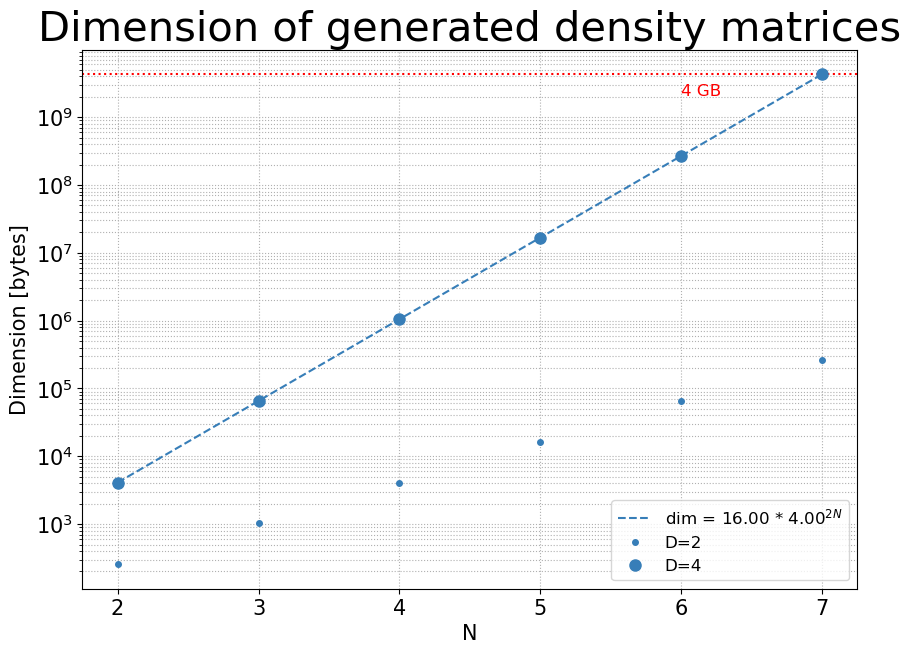

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
D_list = np.sort(np.unique(agg_df["D"]))

# plot all the desider plots
for D_ in D_list:
    plot_df = agg_df[agg_df["D"]==D_]
    ax.errorbar(x="N", y="dim_bytes", data=plot_df,
                fmt="o", c=color_palette[0], ms=2*D_, label=f"D={D_}", capsize=5)

# fit with greatest D
fit_df = agg_df[agg_df["D"]==np.max(D_)]
popt, pcov = curve_fit(f=exp_fit, xdata=fit_df["N"], ydata=fit_df["dim_bytes"], p0=[1.0, 1.0])
ax.plot(fit_df["N"], exp_fit(fit_df["N"], *popt), ls='dashed', label=f"dim = {popt[0]:.2f} * {np.sqrt(popt[1]):.2f}$^{{2N}}$", c=color_palette[0])


ax.set_title("Dimension of generated density matrices", fontsize=30)
ax.set_xlabel("N", fontsize=15)
ax.set_ylabel("Dimension [bytes]", fontsize=15)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.grid(True, which="both", linestyle=":")
ax.axhline(4*2**30, c="r", ls=":")
ax.text(x=np.max(agg_df["N"])-1, y=1.9*2**30, s="4 GB", color="r", fontsize=12)
ax.set_yscale("log")
ax.legend(fontsize=12)

if save_plots:
    fig.savefig("results/densitymatrix_dimension.png", dpi=400, format='png')

### Partial trace testing

In [9]:
parttrace_df = pd.read_csv("results/parttrace_perf.csv", header=0, dtype={"N":int, "D":int})
parttrace_df

,N,D,time
0,2,2,0.002238
1,2,2,0.002013
2,2,2,0.002175
3,2,4,0.013666
4,2,4,0.012852
5,2,4,0.012822
6,4,2,0.013142
7,4,2,0.013839
8,4,2,0.013206
9,4,4,0.744402


In [10]:
# groupby repetitions of the same configuration
# then take the average, std and rename columns 
agg_df = parttrace_df.groupby(["N", "D"]).agg(["mean", "std"])
agg_df.columns = ['_'.join(col) for col in agg_df.columns.to_flat_index().values]
agg_df.reset_index(inplace=True)
agg_df

,N,D,time_mean,time_std
0,2,2,0.002142,0.000116
1,2,4,0.013114,0.000479
2,4,2,0.013395,0.000385
3,4,4,0.748342,0.003633
4,6,2,0.097775,0.001661
5,6,4,42.999331,0.649559


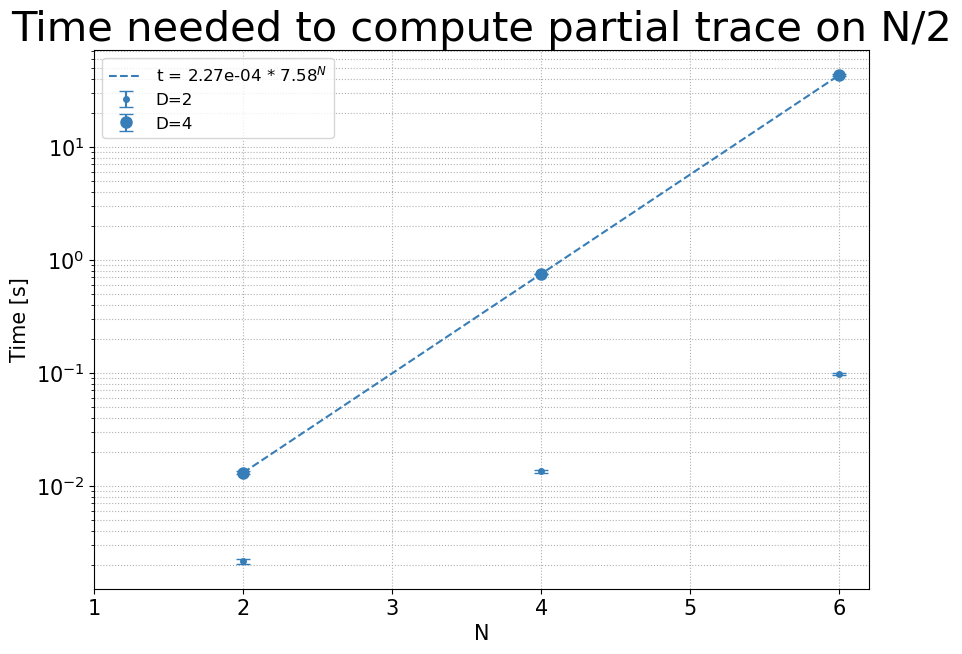

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
D_list = np.sort(np.unique(agg_df["D"]))

# plot all the desider plots
for D_ in D_list:
    plot_df = agg_df[agg_df["D"]==D_]
    ax.errorbar(x="N", y="time_mean", yerr="time_std", data=plot_df,
                fmt="o", c=color_palette[0], ms=2*D_, label=f"D={D_}", capsize=5)

# fit with greatest D
fit_df = agg_df[agg_df["D"]==np.max(D_)]
popt, pcov = curve_fit(f=exp_fit, xdata=fit_df["N"], ydata=fit_df["time_mean"], sigma=fit_df["time_std"], p0=[1.0, 1.0])
ax.plot(fit_df["N"], exp_fit(fit_df["N"], *popt), ls='dashed', label=f"t = {popt[0]:.2e} * {popt[1]:.2f}$^{{N}}$", c=color_palette[0])


ax.set_title("Time needed to compute partial trace on N/2", fontsize=30)
ax.set_xlabel("N", fontsize=15)
ax.set_ylabel("Time [s]", fontsize=15)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.set_xticks(np.unique(np.floor(ax.get_xticks())))
ax.grid(True, which="both", linestyle=":")
ax.set_yscale("log")
ax.legend(fontsize=12)

if save_plots:
    fig.savefig("results/parttrace_time.png", dpi=400, format='png')

### Partial trace test with GHZ state (D=2)

In [27]:
ghztest_df = pd.read_csv("results/maxentang_D2_perf.csv", header=0, dtype={"N":int, "reduced_entropy":float}, comment="#")
ghztest_df

,N,reduced_entropy,time
0,2,1.0,0.001899
1,2,1.0,0.001888
2,2,1.0,0.001893
3,3,1.0,0.006080
4,3,1.0,0.006197
5,3,1.0,0.006615
6,4,1.0,0.022146
7,4,1.0,0.022958
8,4,1.0,0.023815
9,5,1.0,0.088564


In [28]:
# groupby repetitions of the same configuration
# then take the average, std and rename columns 
agg_df = ghztest_df.groupby(["N", "reduced_entropy"]).agg(["mean", "std"])
agg_df.columns = ['_'.join(col) for col in agg_df.columns.to_flat_index().values]
agg_df.reset_index(inplace=True)
agg_df

,N,reduced_entropy,time_mean,time_std
0,2,1.0,0.001893,0.000006
1,3,1.0,0.006297,0.000281
2,4,1.0,0.022973,0.000834
3,5,1.0,0.088929,0.000896
4,6,1.0,0.345804,0.004165
5,7,1.0,1.378256,0.017537
6,8,1.0,5.532482,0.039683
7,9,1.0,21.586469,0.723671
8,10,1.0,84.502421,0.355717
9,11,1.0,340.694323,0.461258


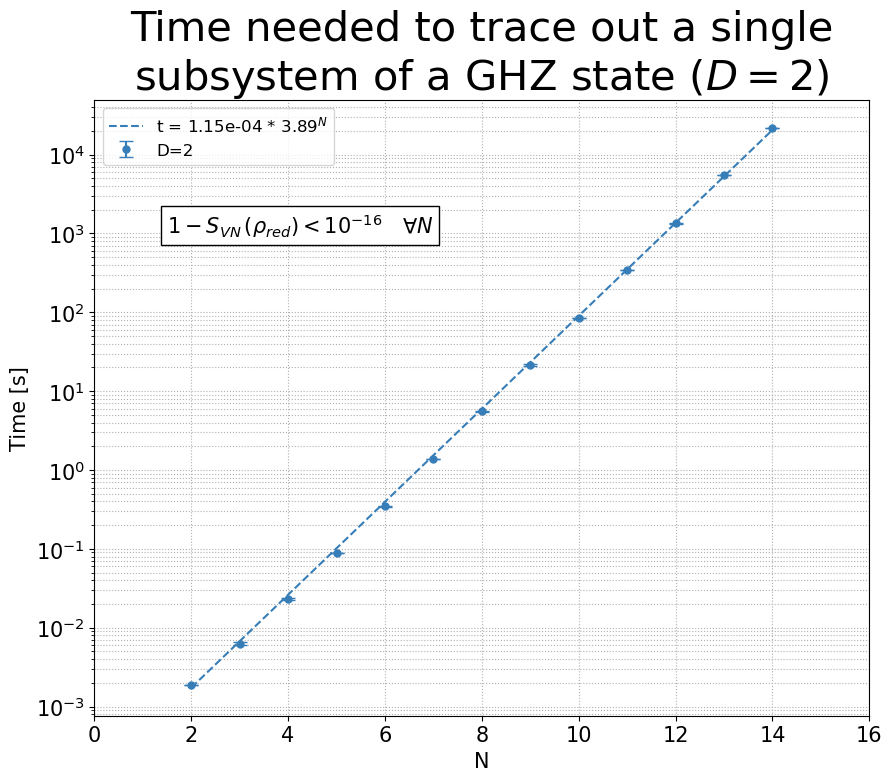

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

# plot all the desider plots
plot_df = agg_df
ax.errorbar(x="N", y="time_mean", yerr="time_std", data=plot_df,
            fmt="o", c=color_palette[0], ms=5, capsize=5, label="D=2")

# fit with greatest D
fit_df = agg_df
popt, pcov = curve_fit(f=exp_fit, xdata=fit_df["N"], ydata=fit_df["time_mean"], sigma=fit_df["time_std"], p0=[1.0e-05, 2.0])
ax.plot(fit_df["N"], exp_fit(fit_df["N"], *popt), ls='dashed', label=f"t = {popt[0]:.2e} * {popt[1]:.2f}$^{{N}}$", c=color_palette[0])

ax.text(x=1.5, y=1000, s=r"$1 - S_{VN}\, (\rho_{red}) < 10^{-16}\quad \forall N$", fontsize=15, bbox=dict(facecolor="w"))


ax.set_title("Time needed to trace out a single\nsubsystem of a GHZ state ($D=2$)", fontsize=30)
ax.set_xlabel("N", fontsize=15)
ax.set_ylabel("Time [s]", fontsize=15)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.set_xticks(np.unique(np.floor(ax.get_xticks())))
ax.grid(True, which="both", linestyle=":")
ax.set_yscale("log")
ax.legend(fontsize=12)

if save_plots:
    fig.savefig("results/maxentang_D2_perf.png", dpi=400, format='png')

In [30]:
1-agg_df["reduced_entropy"]

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
Name: reduced_entropy, dtype: float64

### Scaling of partial trace on half subsystem (D=2, Nred=N/2)

In [31]:
parttrace_D2_df = pd.read_csv("results/parttrace_D2_perf.csv", header=0, dtype={"N":int}, comment="#")
parttrace_D2_df["D"] = 2
parttrace_df = pd.read_csv("results/parttrace_perf.csv", header=0, dtype={"N":int, "D":int})
parttrace_df = pd.concat([parttrace_df, parttrace_D2_df], ignore_index=True)
parttrace_df

,N,D,time
0,2,2,0.002238
1,2,2,0.002013
2,2,2,0.002175
3,2,4,0.013666
4,2,4,0.012852
5,2,4,0.012822
6,4,2,0.013142
7,4,2,0.013839
8,4,2,0.013206
9,4,4,0.744402


In [32]:
# groupby repetitions of the same configuration
# then take the average, std and rename columns 
agg_df = parttrace_df.groupby(["N", "D"]).agg(["mean", "std"])
agg_df.columns = ['_'.join(col) for col in agg_df.columns.to_flat_index().values]
agg_df.reset_index(inplace=True)
agg_df

,N,D,time_mean,time_std
0,2,2,0.002025,0.000154
1,2,4,0.013114,0.000479
2,4,2,0.013101,0.000544
3,4,4,0.748342,0.003633
4,6,2,0.093805,0.004495
5,6,4,42.999331,0.649559
6,8,2,0.700899,0.003745
7,10,2,5.494332,0.037324
8,12,2,43.099737,0.199067
9,14,2,340.774915,NaN


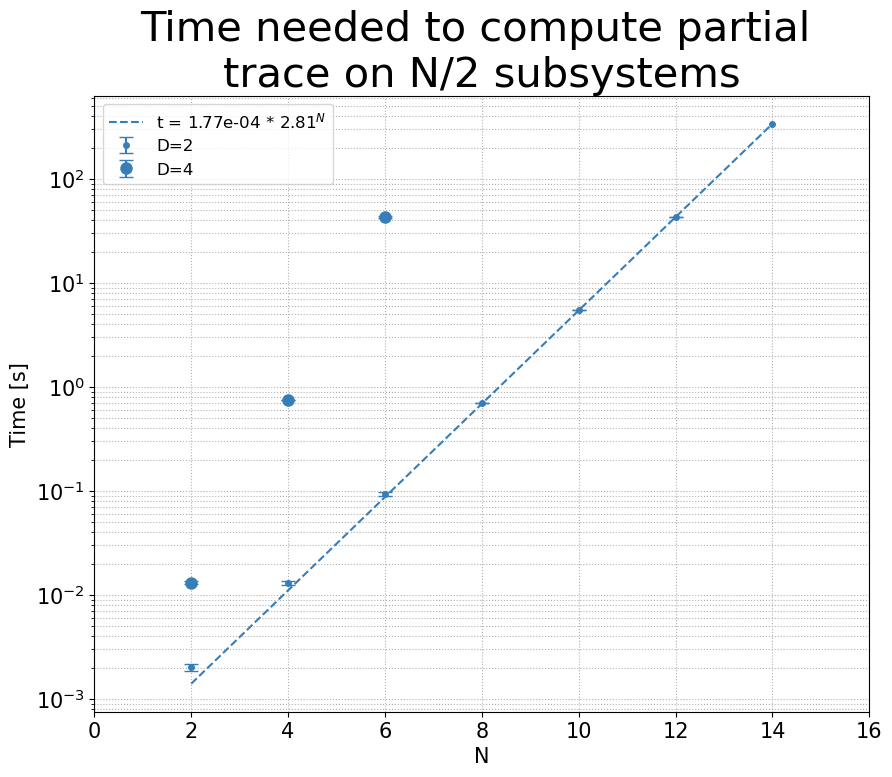

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
D_list = np.sort(np.unique(agg_df["D"]))

# plot all the desider plots
for D_ in D_list:
    plot_df = agg_df[agg_df["D"]==D_]
    ax.errorbar(x="N", y="time_mean", yerr="time_std", data=plot_df,
                fmt="o", c=color_palette[0], ms=2*D_, label=f"D={D_}", capsize=5)

# fit with greatest D
fit_df = agg_df[agg_df["D"]==2]
popt, pcov = curve_fit(f=exp_fit, xdata=fit_df["N"], ydata=fit_df["time_mean"], p0=[1.0e-05, 1.0])
ax.plot(fit_df["N"], exp_fit(fit_df["N"], *popt), ls='dashed', label=f"t = {popt[0]:.2e} * {popt[1]:.2f}$^{{N}}$", c=color_palette[0])


ax.set_title("Time needed to compute partial \ntrace on N/2 subsystems", fontsize=30)
ax.set_xlabel("N", fontsize=15)
ax.set_ylabel("Time [s]", fontsize=15)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.set_xticks(np.unique(np.floor(ax.get_xticks())))
ax.grid(True, which="both", linestyle=":")
ax.set_yscale("log")
ax.legend(fontsize=12)

if save_plots:
    fig.savefig("results/parttrace_D2_time.png", dpi=400, format='png')